Processing Training Data...


Extracting SIFT features: 100%|██████████████████████████████████████████████████████| 495/495 [02:20<00:00,  3.52it/s]


Processing Test Data...


Extracting SIFT features: 100%|██████████████████████████████████████████████████████| 140/140 [00:38<00:00,  3.63it/s]


Training set: 495 total, 43 special, 423 normal with valid descriptors.
Test set: 140 total, 10 special, 121 normal with valid descriptors.
Building vocabulary from 423 images (77077 total descriptors)...
Computing BoW histograms for Normal training images...
Computing BoW histograms for Normal test images...
Training Logistic Regression on Normal images...
Running GridSearchCV...
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\antho\miniconda3\envs\tflabsfall24\lib\site-packages\sklearn\model_selection\_split.py:805: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


Best Logistic Regression Parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}

--- Final Evaluation ---
Overall Test Accuracy: 0.7429


C:\Users\antho\miniconda3\envs\tflabsfall24\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


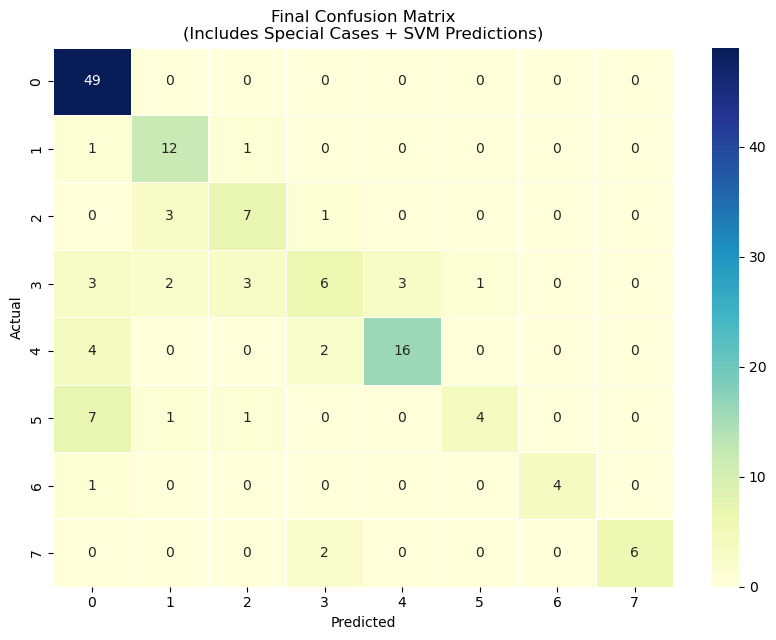

              precision    recall  f1-score   support

           0       0.75      1.00      0.86        49
           1       0.67      0.86      0.75        14
           2       0.58      0.64      0.61        11
           3       0.55      0.33      0.41        18
           4       0.84      0.73      0.78        22
           5       0.80      0.31      0.44        13
           6       1.00      0.80      0.89         5
           7       1.00      0.75      0.86         8

    accuracy                           0.74       140
   macro avg       0.77      0.68      0.70       140
weighted avg       0.75      0.74      0.72       140


Found 36 misclassified images.


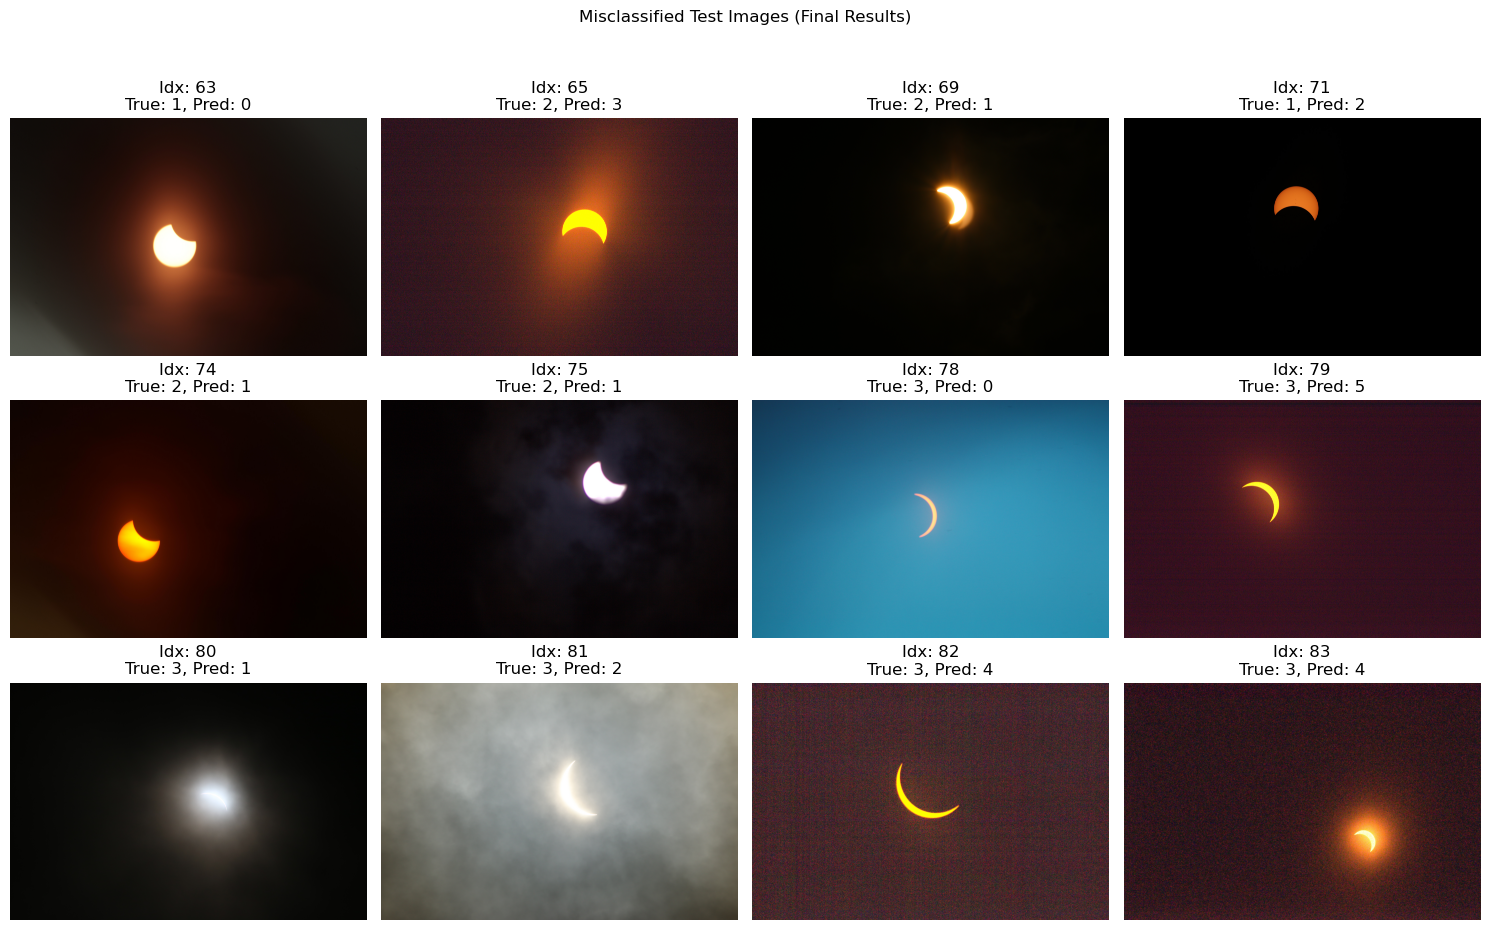

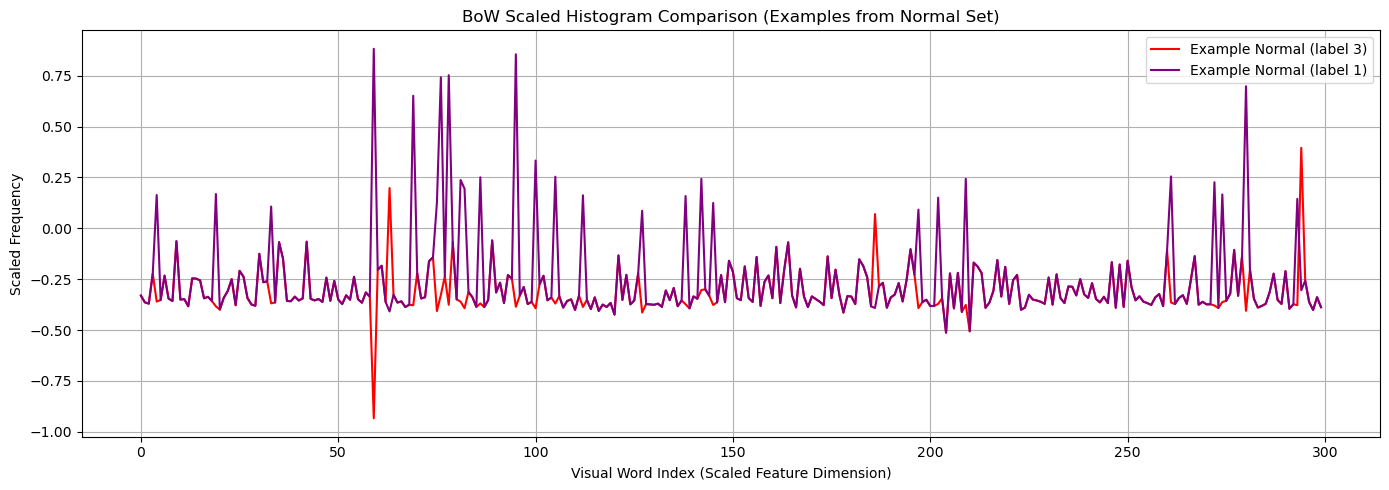


Script finished.


In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- Paths ---
# Make sure these paths are correct for your system
data_dir = 'data'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
label_map_path  = os.path.join(data_dir,'label_num_to_phase_map.json')
train_csv = os.path.join(data_dir, 'train.csv')
test_csv = os.path.join(data_dir, 'test.csv')

# --- Load label files ---
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# --- Add full paths ---
train_df['path'] = train_df['image_id'].apply(lambda x: os.path.join(train_dir, x))
test_df['path'] = test_df['image_id'].apply(lambda x: os.path.join(test_dir, x))

# --- Preprocessing ---
def preprocess_image(path, size=(256, 256)):
    img = cv2.imread(path) # read image from file path
    if img is None: # handle error image
        print(f"Warning: Could not read image {path}")
        return None
    img = cv2.resize(img, size) # resize to 256x256
    img = cv2.GaussianBlur(img, (3, 3), 0) # apply gaussian blur
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # convert image to grayscale
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8)) # create CLAHE
    return clahe.apply(gray) # return preprocessed image, CLAHE applied

# --- Special Case Classification ---
def classify_flat_or_dark(img, flat_std_thresh=8, dark_mean_thresh=25, dark_std_thresh=6, debug=False, path=""):
    """ Classify an image as Flat (6), Dark (4), or Unknown (None). """
    if img is None:
        return None

    mean_intensity = np.mean(img)
    std_intensity = np.std(img)
    median_intensity = np.median(img)
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    dominant_pixel = np.argmax(hist)

    if debug:
        print(f"[DEBUG] {path} -> Mean: {mean_intensity:.2f}, Std: {std_intensity:.2f}, Median: {median_intensity:.2f}, Dominant pixel: {dominant_pixel}")
        # (Optional: add histogram plotting code here if needed)

    # Rule for Dark: very dim, low contrast, dominant near 0
    if mean_intensity < dark_mean_thresh and std_intensity < dark_std_thresh and dominant_pixel < 20:
        return 4  # Dark

    # Rule for Flat: bright or mid-bright, but low variation, dominant peak not too dark
    elif mean_intensity > 80 and std_intensity < flat_std_thresh and dominant_pixel > 50:
        return 6  # Flat

    return None # Otherwise unknown

# --- SIFT - feature extract (No change needed here) ---
def extract_sift_descriptors(df):
    sift = cv2.SIFT_create(contrastThreshold=0.075, edgeThreshold=12)
    descriptors_list = []
    special_classifications = [] # Store special class (4 or 6) or None

    for idx, row in tqdm(df.iterrows(), total=len(df), desc="Extracting SIFT features"):
        path = row['path']
        img_orig = cv2.imread(path) # Read original for classification
        if img_orig is None:
            print(f"Warning: Could not read original image {path} for special classification.")
            descriptors_list.append(None)
            special_classifications.append(None)
            continue

        img_gray_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)

        # --- Early classify as Flat or Dark based on original grayscale image ---
        special_class = classify_flat_or_dark(img_gray_orig, debug=False, path=path)

        if special_class is not None:
            special_classifications.append(special_class) # Store 4 or 6
            descriptors_list.append(None) # No descriptors needed
            continue  # Skip SIFT extraction

        # --- If not Flat/Dark, proceed with preprocessing and SIFT ---
        special_classifications.append(None) # Mark as not special
        gray_processed = preprocess_image(path) # Preprocess for SIFT

        if gray_processed is None:
            descriptors_list.append(None) # Preprocessing failed
            continue

        keypoints, descriptors = sift.detectAndCompute(gray_processed, None)

        # Handle cases where no keypoints are found even if not Flat/Dark
        if descriptors is None or len(descriptors) == 0:
             descriptors_list.append(None)
        else:
            descriptors_list.append(descriptors)


    return descriptors_list, special_classifications

# --- KMeans Vocabulary Building (No change needed here) ---
def build_vocabulary(descriptors_list_normal, vocab_size):
    # Input should ONLY contain descriptors from non-Flat/Dark images
    descriptors = [desc for desc in descriptors_list_normal if desc is not None]
    if not descriptors:
        raise ValueError("No valid descriptors found to build vocabulary. Check SIFT extraction and filtering.")
    descriptors_stacked = np.vstack(descriptors)
    print(f"Building vocabulary from {len(descriptors)} images ({descriptors_stacked.shape[0]} total descriptors)...")
    kmeans = KMeans(n_clusters=vocab_size, random_state=42, n_init=10) # n_init added for stability
    kmeans.fit(descriptors_stacked)
    return kmeans

# --- Compute BoW Histograms (Slight adaptation for clarity/safety) ---
def compute_bow_histograms_normal(descriptors_list_normal, kmeans):
    # Input should ONLY contain descriptors from non-Flat/Dark images
    # Assumes Nones are filtered *before* calling or handled if passed
    vocab_size = kmeans.n_clusters
    histograms = []

    for descriptors in descriptors_list_normal:
        if descriptors is None or len(descriptors) == 0:
            # This case should ideally be minimized by filtering, but handle defensively
            hist = np.zeros(vocab_size)
        else:
            words = kmeans.predict(descriptors)
            hist, _ = np.histogram(words, bins=np.arange(vocab_size + 1))
        histograms.append(hist)

    return np.array(histograms)

# --- Execute Feature Extraction ---
print("Processing Training Data...")
train_descriptors_all, special_classifications_train = extract_sift_descriptors(train_df)
print("Processing Test Data...")
test_descriptors_all, special_classifications_test = extract_sift_descriptors(test_df)

# --- Filter Data: Separate Normal images from Flat/Dark ---

# 1. Get Indices
normal_train_indices = [i for i, sc in enumerate(special_classifications_train) if sc is None]
special_train_indices = [i for i, sc in enumerate(special_classifications_train) if sc is not None]
normal_test_indices = [i for i, sc in enumerate(special_classifications_test) if sc is None]
special_test_indices = [i for i, sc in enumerate(special_classifications_test) if sc is not None]

# 2. Filter Descriptors and Labels for NORMAL images (Handling potential None descriptors)
train_descriptors_normal_valid = []
y_train_normal_indices = [] # Keep track of original indices for labels
for i in normal_train_indices:
    if train_descriptors_all[i] is not None and len(train_descriptors_all[i]) > 0:
        train_descriptors_normal_valid.append(train_descriptors_all[i])
        y_train_normal_indices.append(i) # Store the original index

test_descriptors_normal_valid = []
y_test_normal_indices = [] # Keep track of original indices for combining later
for i in normal_test_indices:
     if test_descriptors_all[i] is not None and len(test_descriptors_all[i]) > 0:
        test_descriptors_normal_valid.append(test_descriptors_all[i])
        y_test_normal_indices.append(i) # Store the original index

# 3. Get Labels for NORMAL training images
y_train_normal = train_df['label'].values[y_train_normal_indices]

print(f"Training set: {len(train_df)} total, {len(special_train_indices)} special, {len(y_train_normal_indices)} normal with valid descriptors.")
print(f"Test set: {len(test_df)} total, {len(special_test_indices)} special, {len(y_test_normal_indices)} normal with valid descriptors.")

if not y_train_normal_indices:
    raise SystemExit("Error: No 'normal' images with valid descriptors found in the training set. Cannot proceed.")


# --- Build Vocabulary (using ONLY normal training images) ---
vocab_size = 300
kmeans = build_vocabulary(train_descriptors_normal_valid, vocab_size)

# --- Compute BoW Histograms (using ONLY normal images) ---
print("Computing BoW histograms for Normal training images...")
X_train_normal = compute_bow_histograms_normal(train_descriptors_normal_valid, kmeans)
print("Computing BoW histograms for Normal test images...")
X_test_normal = compute_bow_histograms_normal(test_descriptors_normal_valid, kmeans)

# --- Normalize Features (using ONLY normal images) ---
scaler = StandardScaler()
X_train_scaled_normal = scaler.fit_transform(X_train_normal)
# Check if X_test_normal is empty before transforming
if X_test_normal.shape[0] > 0:
    X_test_scaled_normal = scaler.transform(X_test_normal)
else:
    # Handle case where there are no normal test images with descriptors
    X_test_scaled_normal = np.empty((0, vocab_size))
    print("Warning: No 'normal' test images with valid descriptors found.")


print("Training Logistic Regression on Normal images...")
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'max_iter': [200]
}

print("Running GridSearchCV...")
if X_train_scaled_normal.shape[0] > 0:
    grid = GridSearchCV(LogisticRegression(), param_grid, cv=min(3, X_train_scaled_normal.shape[0]), verbose=2, n_jobs=-1)
    grid.fit(X_train_scaled_normal, y_train_normal)
    print("Best Logistic Regression Parameters:", grid.best_params_)
    clf = grid.best_estimator_
else:
    raise SystemExit("Error: Cannot train Logistic Regression, no valid normal training samples.")


# --- Predict with SVM (on ONLY normal test images) ---
# Ensure there's data to predict on
if X_test_scaled_normal.shape[0] > 0:
    y_pred_normal = clf.predict(X_test_scaled_normal)
else:
    y_pred_normal = np.array([], dtype=int) # No predictions if no normal test images


# --- Combine Predictions and Ground Truth ---

# 1. Final Ground Truth (y_test_final)
y_test_final = test_df['label'].values.copy() # Start with original labels
for i in special_test_indices:
    y_test_final[i] = special_classifications_test[i] # Override with special class

# 2. Final Predictions (y_pred_final)
y_pred_final = np.zeros(len(test_df), dtype=int) # Initialize

# Fill in special classifications
for i in special_test_indices:
    y_pred_final[i] = special_classifications_test[i]

# Fill in SVM predictions for normal images
# Ensure the lengths match before assigning
if len(y_pred_normal) == len(y_test_normal_indices):
    for pred_idx, original_idx in enumerate(y_test_normal_indices):
        y_pred_final[original_idx] = y_pred_normal[pred_idx]
elif len(y_pred_normal) == 0 and len(y_test_normal_indices) == 0:
     print("No normal test images to predict.")
else:
    print(f"Warning: Mismatch in length of normal predictions ({len(y_pred_normal)}) and normal indices ({len(y_test_normal_indices)}). Predictions might be incomplete.")
    # Handle potential mismatches cautiously if necessary, e.g., leave as 0 or assign a specific error code


# --- Evaluate FINAL Results ---
print("\n--- Final Evaluation ---")
if len(y_test_final) > 0:
    acc = accuracy_score(y_test_final, y_pred_final)
    print(f"Overall Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    # Dynamically get unique labels present in both true and pred for matrix plotting
    labels = sorted(list(set(y_test_final) | set(y_pred_final)))
    cm = confusion_matrix(y_test_final, y_pred_final, labels=labels)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    plt.figure(figsize=(10, 7))
    plt.title("Final Confusion Matrix\n(Includes Special Cases + SVM Predictions)")
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="YlGnBu", cbar=True, linewidths=0.5)
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    print(classification_report(y_test_final, y_pred_final, labels=labels, zero_division=0))
else:
    print("No test data to evaluate.")


# --- Visualize Misclassified Images (Using Final Results) ---
if len(y_test_final) > 0:
    misclassified_indices = np.where(y_pred_final != y_test_final)[0]
    print(f"\nFound {len(misclassified_indices)} misclassified images.")

    # Number of misclassified images to show
    num_to_show = min(12, len(misclassified_indices)) # Show up to 12 or fewer if less are misclassified
    if num_to_show > 0:
        plt.figure(figsize=(15, 10))
        plot_rows = (num_to_show + 3) // 4 # Calculate rows needed for a 4-column layout
        for i, idx in enumerate(misclassified_indices[:num_to_show]):
            path = test_df.iloc[idx]['path']
            true_label = y_test_final[idx]
            predicted_label = y_pred_final[idx]

            img = cv2.imread(path)
            if img is None:
                print(f"Warning: Could not read image {path} for misclassified visualization.")
                # Optionally plot a placeholder
                ax = plt.subplot(plot_rows, 4, i + 1)
                ax.set_title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label}\n(Image Read Error)")
                ax.axis('off')
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            plt.subplot(plot_rows, 4, i + 1)
            plt.imshow(img)
            plt.title(f"Idx: {idx}\nTrue: {true_label}, Pred: {predicted_label}")
            plt.axis('off')

        plt.suptitle("Misclassified Test Images (Final Results)")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
        plt.show()


# --- Visualize Histogram Comparison (Focus on NORMAL classes) ---
# Find examples within the NORMAL, SCALED training data
if X_train_scaled_normal.shape[0] > 0:
    try:
        # Find first index in the 'normal' set corresponding to a specific original label
        partial_label_to_find = 3 # Example: 56–95% Partial Eclipse
        # Find the first occurrence of this label *within the set used for training SVM*
        target_indices_in_normal_set = np.where(y_train_normal == partial_label_to_find)[0]

        if len(target_indices_in_normal_set) > 0:
            partial_idx_in_normal = target_indices_in_normal_set[0]
            partial_hist = X_train_scaled_normal[partial_idx_in_normal]

            # Maybe compare two different 'normal' classes if available
            other_label_to_find = 1 # Example: 1-25% Partial Eclipse
            other_indices_in_normal_set = np.where(y_train_normal == other_label_to_find)[0]
            other_hist = None
            if len(other_indices_in_normal_set) > 0:
                 other_idx_in_normal = other_indices_in_normal_set[0]
                 other_hist = X_train_scaled_normal[other_idx_in_normal]


            # Plot
            plt.figure(figsize=(14, 5))
            plt.plot(partial_hist, label=f"Example Normal (label {partial_label_to_find})", color='red')
            if other_hist is not None:
                 plt.plot(other_hist, label=f"Example Normal (label {other_label_to_find})", color='purple')

            plt.title("BoW Scaled Histogram Comparison (Examples from Normal Set)")
            plt.xlabel("Visual Word Index (Scaled Feature Dimension)")
            plt.ylabel("Scaled Frequency")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()
        else:
            print(f"Could not find example of label {partial_label_to_find} in the normal training set for histogram visualization.")

    except Exception as e:
        print(f"Could not generate histogram comparison plot: {e}")
else:
    print("Skipping histogram comparison: No normal training data available.")

print("\nScript finished.")